In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tinygp import kernels, GaussianProcess

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.linen.initializers import zeros

import optax

from thesis.io import mesa, gyre, fgong
from thesis.physics import first_adiabatic_exponent, sound_speed, acoustic_depth, structure_kernels
from thesis.calculus import differentiate

In [5]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
gong = fgong.load_fgong(filename)
gong

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [6]:
summary_filename = os.path.join(root_path, profile_name, "summary.h5")
detail_filenames = glob(os.path.join(root_path, profile_name, "detail*"))

pulse = gyre.load_output(summary_filename, detail_filenames)
pulse

<xarray.Dataset>
Dimensions:  (n_pg: 36, l: 3, x: 1046)
Coordinates:
  * n_pg     (n_pg) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * l        (l) int64 0 1 2
  * x        (x) float64 0.0 0.0009072 0.001143 0.00144 ... 1.001 1.001 1.001
Data variables:
    E_norm   (n_pg, l) float64 0.005267 nan 0.002007 ... 8.809e-09 nan nan
    freq     (n_pg, l) complex128 (255.42893986791924+0j) ... (nan+nanj)
    omega    (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As       (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2      (x, n_pg, l) float64 125.5 nan 125.5 125.5 ... 5.896e+03 nan nan
    c_1      (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
    xi_r     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
Attributes:
    freq_units:  UHZ
    label:

In [7]:
data = gong.merge(pulse, combine_attrs="drop_conflicts")
data

<xarray.Dataset>
Dimensions:       (x: 1046, n_pg: 36, l: 3)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
  * n_pg          (n_pg) int64 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
  * l             (l) int64 0 1 2
Data variables: (12/44)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    omega         (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As            (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2           (x, n_pg, l) float64 125.5 nan 125.5 ... 5.896e+03 nan nan
    c_1           (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
    xi_r          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
Attributes: (12/17)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08
    freq_units:      UHZ
    label:

In [8]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


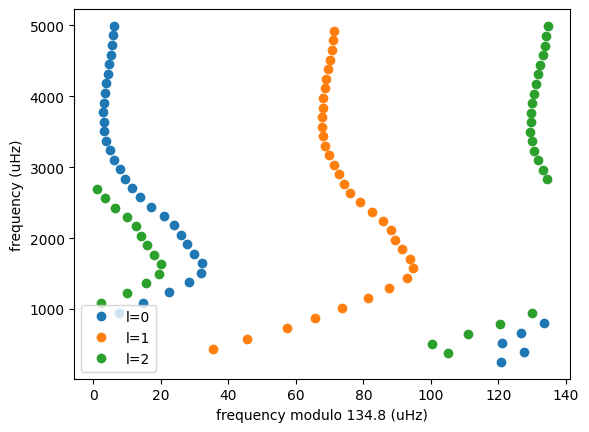

In [9]:
fig = plt.figure()

freq_mod = data.freq.real%nu0
for j in data.l:
    plt.plot(freq_mod.sel(l=j), data.freq.real.sel(l=j), 'o', color=f'C{j:d}', label=f'l={j:d}')
#     plt.plot(freq_mod.sel(l=j)-nu0, ds.freq.real.sel(l=j), 'o', color=f'C{j:d}')

plt.xlabel(f'frequency modulo {nu0:.1f} (uHz)')
plt.ylabel('frequency (uHz)')
plt.legend();

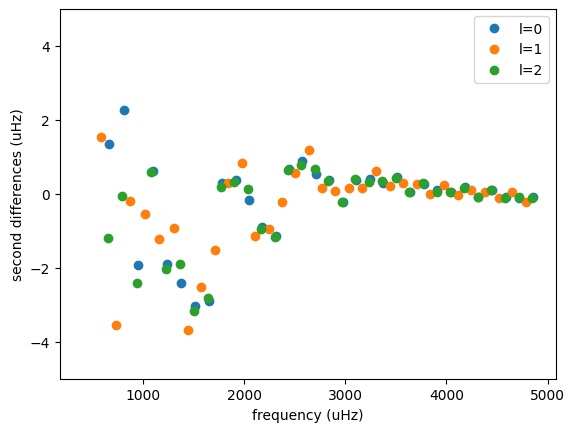

In [10]:
plt.figure()

d2nu = data.freq.real[:-2].values - 2 * data.freq.real[1:-1].values + data.freq.real[2:].values

for j in range(3):
    plt.plot(data.freq.real[1:-1, j], d2nu[:, j], 'o', color=f'C{j:d}', label=f'l={data.l[j]:d}')

plt.xlabel('frequency (uHz)')
plt.ylabel('second differences (uHz)')
plt.ylim(-5, 5)
plt.legend();

In [18]:
n = np.arange(12, 28)
nu = data.freq.real.sel(n_pg=n, l=0).values

In [87]:
delta_nu = np.diff(nu).mean()

In [92]:
def asymptotic(n, nu_max, delta_nu, epsilon, kappa=0.0):
    n_max = nu_max / delta_nu - epsilon
    return delta_nu * (kappa * (n - n_max)**2 + n + epsilon)

def oscillation(nu, tau, phi):
    return jnp.sin(4*jnp.pi*tau*nu + phi)

def he_glitch(nu, a, b, tau, phi):
    return a * nu * jnp.exp(- b * nu**2) * oscillation(nu, tay, phi)

def cz_glitch(nu, a, tau, phi):
    return a / nu**2 * oscillation(nu, tau, phi)

class Model(nn.Module):
    @nn.compact
    def __call__(self, n, nu, n_pred=None):
        
#         log_nu_max = self.param("log_nu_max", zeros, ())
#         log_delta_nu = self.param("log_delta_nu", zeros, ())
        log_epsilon = self.param("log_epsilon", zeros, ())
#         log_kappa = self.param("log_kappa", zeros, ())        
        
#         mean = asymptotic(n, jnp.exp(log_nu_max), jnp.exp(log_delta_nu), jnp.exp(log_epsilon), jnp.exp(log_kappa))
        
        def mean(n):
            return n + jnp.exp(log_epsilon)

#         nu_asy = asymptotic(n, jnp.exp(log_nu_max), jnp.exp(log_delta_nu), jnp.exp(log_epsilon), jnp.exp(log_kappa))
#         dnu_he = he_glitch(nu_asy, jnp.exp(log_a_he), jnp.exp(log_b_he), jnp.exp(log_tau_he), phi_he)
#         dnu_cz = cz_glitch(nu_asy, jnp.exp(log_a_cz), jnp.exp(log_tau_cz), phi_cz)
#         mean = nu_asy
        
        log_jitter = self.param("log_jitter", zeros, ())

        log_amp = self.param("log_amp", zeros, ())
        log_scale = self.param("log_scale", zeros, ())
        kernel = (
            jnp.exp(log_amp)
            * kernels.ExpSquared(jnp.exp(log_scale))
        )

        gp = GaussianProcess(
            kernel, n, diag=jnp.exp(log_jitter), mean=mean
        )
        
        if n_pred is None:
            return - gp.log_probability(nu)

        log_prob, cond = gp.condition(nu, n_pred)
        return - log_prob, cond.loc

def loss(params):
    return model.apply(params, n, nu/delta_nu)

In [93]:
rng = jax.random.PRNGKey(0)

In [94]:
rng, key = jax.random.split(rng)

model = Model()
params = model.init(key, n, nu/delta_nu)
tx = optax.adam(learning_rate=1e-2)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

In [95]:
num_iter = 1001
losses = []
for i in range(num_iter):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

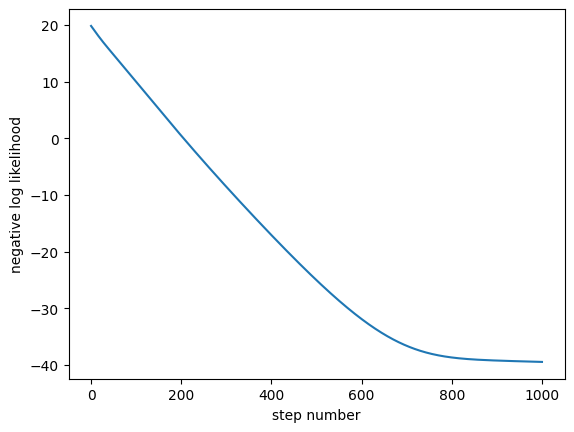

In [97]:
plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")
# plt.yscale("log")

In [98]:
n_pred = np.linspace(n.min(), n.max(), 101)
_, nu_pred = model.apply(params, n, nu/delta_nu, n_pred=n_pred)
_, nu_fit = model.apply(params, n, nu/delta_nu, n_pred=n)

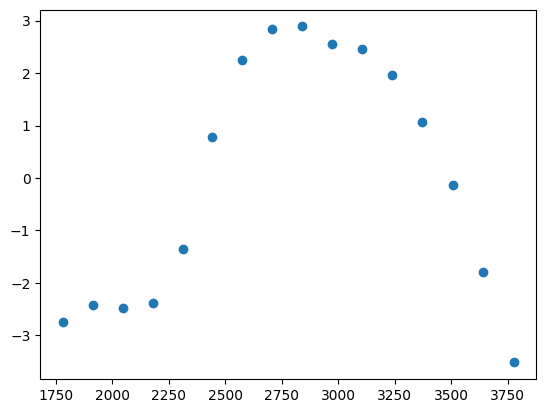

In [101]:
plt.plot(nu, delta_nu*nu_fit - nu, "o")

In [73]:
params

FrozenDict({
    params: {
        log_amp: Array(0.8490491, dtype=float32),
        log_delta_nu: Array(0.26624098, dtype=float32),
        log_epsilon: Array(3.0763216, dtype=float32),
        log_jitter: Array(0.768282, dtype=float32),
        log_kappa: Array(0.20808055, dtype=float32),
        log_nu_max: Array(-0.84496194, dtype=float32),
        log_scale: Array(0.7288144, dtype=float32),
    },
})

In [79]:
np.exp(params["params"]["log_nu_max"])

0.42957368